In [1]:
import sys

sys.path.append("./../../src")


from Dataset import SpeechCommandsDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
test_dataset = SpeechCommandsDataset("./../../data/test")
train_dataset = SpeechCommandsDataset("./../../data/train")

In [3]:
class SpeechCommandGRU(nn.Module):
    def __init__(self, input_size=40, hidden_size=128, num_layers=2, num_classes=35):
        super(SpeechCommandGRU, self).__init__()

        # Apply a 1D Conv to reduce dimensionality and extract features
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=80, stride=40),  # (16000 -> 400)
            nn.ReLU(),
            nn.Conv1d(32, input_size, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
        )

        # Output layer
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = x.squeeze(1)
        x = x.unsqueeze(1)  # (batch, 1, 16000)
        x = self.conv(x)  # (batch, input_size, time_steps)
        x = x.permute(0, 2, 1)  # (batch, time_steps, input_size)
        out, _ = self.rnn(x)  # (batch, time_steps, hidden_size*2)
        out = out[:, -1, :]  # Use last timestep
        out = self.fc(out)  # (batch, num_classes)
        return out

In [4]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for waveforms, labels in dataloader:
            waveforms, labels = waveforms.to(device), labels.to(device)
            outputs = model(waveforms)  # shape: (batch_size, num_classes)
            _, predicted = torch.max(outputs, 1)  # Get predicted class index
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.2%}")
    return accuracy

In [5]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)

model = SpeechCommandGRU(num_classes=31).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    model.train()
    for waveforms, labels in train_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)
        outputs = model(waveforms)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 3.3916
Epoch 2, Loss: 1.1014
Epoch 3, Loss: 1.1267
Epoch 4, Loss: 0.8833
Epoch 5, Loss: 0.4399
Epoch 6, Loss: 0.5149
Epoch 7, Loss: 0.2859
Epoch 8, Loss: 0.4983
Epoch 9, Loss: 0.0409
Epoch 10, Loss: 0.1348


In [6]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test_accuracy = evaluate(model, test_loader, device)

Test Accuracy: 89.53%


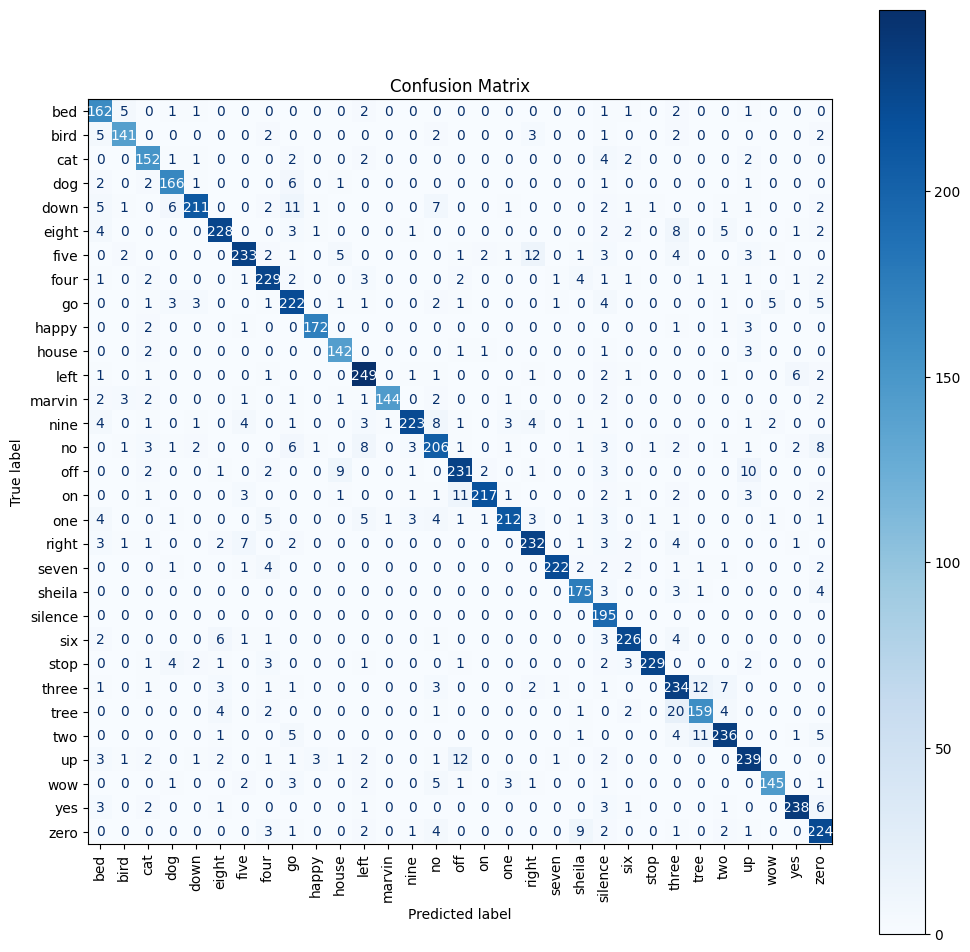

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def get_all_preds(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for waveforms, labels in dataloader:
            waveforms, labels = waveforms.to(device), labels.to(device)
            outputs = model(waveforms)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds


true_labels, pred_labels = get_all_preds(model, test_loader, device)

# Optional: get label names
label_names = list(test_dataset.class_to_idx.keys())

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(include_values=True, xticks_rotation="vertical", ax=ax, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()